In [2]:
import cv2
from keras.models import load_model
import onnx
import onnxruntime as ort
from onnx_tf.backend import prepare
import numpy as np

Using TensorFlow backend.
C:\Users\KUSHAL MASTER\Anaconda3\lib\site-packages\onnx_tf\common\__init__.py:89: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.











In [3]:
def area_of(left_top, right_bottom):
    """
    Compute the areas of rectangles given two corners.
    Args:
        left_top (N, 2): left top corner.
        right_bottom (N, 2): right bottom corner.
    Returns:
        area (N): return the area.
    """
    hw = np.clip(right_bottom - left_top, 0.0, None)
    return hw[..., 0] * hw[..., 1]

def iou_of(boxes0, boxes1, eps=1e-5):
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Args:
        boxes0 (N, 4): ground truth boxes.
        boxes1 (N or 1, 4): predicted boxes.
        eps: a small number to avoid 0 as denominator.
    Returns:
        iou (N): IoU values.
    """
    overlap_left_top = np.maximum(boxes0[..., :2], boxes1[..., :2])
    overlap_right_bottom = np.minimum(boxes0[..., 2:], boxes1[..., 2:])

    overlap_area = area_of(overlap_left_top, overlap_right_bottom)
    area0 = area_of(boxes0[..., :2], boxes0[..., 2:])
    area1 = area_of(boxes1[..., :2], boxes1[..., 2:])
    return overlap_area / (area0 + area1 - overlap_area + eps)

def hard_nms(box_scores, iou_threshold, top_k=-1, candidate_size=200):
    """
    Perform hard non-maximum-supression to filter out boxes with iou greater
    than threshold
    Args:
        box_scores (N, 5): boxes in corner-form and probabilities.
        iou_threshold: intersection over union threshold.
        top_k: keep top_k results. If k <= 0, keep all the results.
        candidate_size: only consider the candidates with the highest scores.
    Returns:
        picked: a list of indexes of the kept boxes
    """
    scores = box_scores[:, -1]
    boxes = box_scores[:, :-1]
    picked = []
    indexes = np.argsort(scores)
    indexes = indexes[-candidate_size:]
    while len(indexes) > 0:
        current = indexes[-1]
        picked.append(current)
        if 0 < top_k == len(picked) or len(indexes) == 1:
            break
        current_box = boxes[current, :]
        indexes = indexes[:-1]
        rest_boxes = boxes[indexes, :]
        iou = iou_of(
            rest_boxes,
            np.expand_dims(current_box, axis=0),
        )
        indexes = indexes[iou <= iou_threshold]

    return box_scores[picked, :]

def predict(width, height, confidences, boxes, prob_threshold, iou_threshold=0.5, top_k=-1):
    """
    Select boxes that contain human faces
    Args:
        width: original image width
        height: original image height
        confidences (N, 2): confidence array
        boxes (N, 4): boxes array in corner-form
        iou_threshold: intersection over union threshold.
        top_k: keep top_k results. If k <= 0, keep all the results.
    Returns:
        boxes (k, 4): an array of boxes kept
        labels (k): an array of labels for each boxes kept
        probs (k): an array of probabilities for each boxes being in corresponding labels
    """
    boxes = boxes[0]
    confidences = confidences[0]
    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, confidences.shape[1]):
        probs = confidences[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = np.concatenate([subset_boxes, probs.reshape(-1, 1)], axis=1)
        box_probs = hard_nms(box_probs,
           iou_threshold=iou_threshold,
           top_k=top_k,
           )
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])
    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])
    picked_box_probs = np.concatenate(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    return picked_box_probs[:, :4].astype(np.int32), np.array(picked_labels), picked_box_probs[:, 4]

In [5]:
cnt = 1
coords = []
image_list = []
def detect_face(image):
    global cnt
    image = cv2.resize(image,(640,480))
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_mean = np.array([127, 127, 127])
    img = (img - img_mean) / 128
    img = np.transpose(img, [2, 0, 1])
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32)
    onnx_model = onnx.load('Copy of ultra_light_640.onnx')
    predictor = prepare(onnx_model)
    ort_session = ort.InferenceSession('Copy of ultra_light_640.onnx')
    input_name = ort_session.get_inputs()[0].name
    confidences, boxes = ort_session.run(None, {input_name: img})
    h,w,_ = image.shape
    boxes, labels, probs = predict(w, h, confidences, boxes, 0.7)
    cnt = 0
    for i in range(boxes.shape[0]):
            if probs[cnt]>0.99:
                box = boxes[i, :]
                x1, y1, x2, y2 = box
                image = image[y1:y2,x1:x2]
                if image.shape[0]<=0 or image.shape[1]<=0 or len(image)==0:
                      continue
                coords.append((x1, y1, x2, y2))
                image_list.append(image)
            cnt = cnt + 1
    return coords, image_list

In [6]:
model = load_model('vgg_mask.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



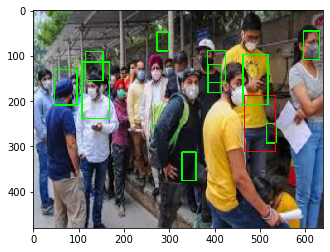

In [22]:
import matplotlib.pyplot as plt
img = cv2.imread("1.jpg")
original_img = img.copy()
box,img_list = detect_face(img)
for images,b in zip(img_list,box):
    images = cv2.cvtColor(images,cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(224,224))
    images = images/255.0
    pred = model.predict(images[np.newaxis,...])
    flag = 0
    if pred[0][0] < pred[0][1]:
        flag = 1
    if flag == 0:
        x1, y1, x2, y2 = b
        original_img = cv2.resize(original_img,(640,480))
        cv2.rectangle(original_img, (x1, y1-5), (x2, y2+5), (0,255,0), 2)
    else:
        x1, y1, x2, y2 = b
        original_img = cv2.resize(original_img,(640,480))
        cv2.rectangle(original_img, (x1, y1-5), (x2, y2+5), (0,0,255), 2)
plt.imshow(cv2.cvtColor(original_img,cv2.COLOR_RGB2BGR))
plt.show()